In [1]:
#import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter
import re
import os
import nltk
from wordcloud import WordCloud
from dateutil.parser import parse
import operator
from uuid import uuid4
import sys
import warnings
warnings.filterwarnings("ignore")

#from textblob import Word
from nltk.tag import pos_tag
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk import download as nltk_download
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.datasets.twenty_newsgroups import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
sns.set(style="darkgrid")


#nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words=stopwords.words('english')

In [2]:
#load in full dataset
mdb = pd.read_csv('exports/Measure.csv')

In [3]:
mdb.drop(['Unnamed: 0'], axis=1, inplace=True)
mdb.drop(['Unnamed: 0.1'], axis=1, inplace=True)

### Table of Contents
(click to jump to)

#### [Summary](#summary)
#### [Countries](#countries)
#### [Years](#years)
#### [Status](#status)
#### [Finance](#finance)
#### [Targets](#targets)
#### [Jurisdiction](#jurisdiction)
#### [Agencies](#agencies)
#### [GHG data](#ghg)



### Summary stats <a id='summary'></a>

**The dataset is the aggregation of publicly available online documentation on measures aimed at mitigating climate change. We make no claim to have documentation on all measures mitigating climate change globally, however all sources used to compile this dataset had some form of contact with official agencies in countries represented in the dataset.  More information on each source and its original formatting can be found <a href="https://github.com/Dlindse/gccmdb/blob/master/GCCMDB%20Source%20List.pdf">here.</a>

In [4]:
#total number of records
print('Current number of records in climate change mitigation measures dataset:', len(mdb), '\n')

#total number of columns
print('Number of features (columns) in climate change mitigation measures dataset:', len(mdb.columns.tolist()), '\n')

#columns in dataset with number of records represented
print('Columns in dataset: \n\t'+ '\n\t'.join(mdb.columns.tolist()), '\n')


#number of NA values for each column

Current number of records in climate change mitigation measures dataset: 11181 

Number of features (columns) in climate change mitigation measures dataset: 30 

Columns in dataset: 
	agency
	city
	country
	country_region
	data_source
	description
	ghgs_affected
	impact_evaluation
	impact_on_eu_ets_esd_or_lulucf_emissions
	jurisdiction
	link
	name
	percent_private_funded
	measure_financing_period_start
	measure_financing_quantity
	measure_implementation_period_end_year
	measure_implementation_period_start_year
	measure_status
	measure_target
	measure_type
	measure_written_year
	related_documents
	related_to_eu_policy
	related_to_eu_policy_boolean
	related_to_neeap_policy
	related_to_neeap_policy_boolean
	total_ghg_emissions_reductions_in_2020
	total_ghg_emissions_reductions_in_2030
	world_region
	uuid 



### Countries <a id='countries'></a>

In [5]:
#countries in dataset

#get country list
countries = mdb['country'].tolist()
countries = set(countries)

csf = {}

for c in countries:
    
    y = mdb[mdb['country'] == c]['measure_implementation_period_start_year'].tolist()
    y = ['{}'.format(x) for x in y]
    hold = []
    for i in y:
        r = re.match(r"([0-9])\w+", i)
        if r is not None:
            hold.append(r.group(0))
        
    csf[c] = hold
    
measurebycountry = {}

for key, value in csf.items():
    
    measurebycountry[key] = len(value)
    

print('Number of reporting countries in the dataset:', len(set(mdb['country'].tolist())), '\n')

print('Countries represented in dataset with number of reported measures: \n')

for c in sorted(measurebycountry.items(), key=operator.itemgetter(1)):
    print('\t' + c[0] + ': ' + str(c[1]))


Number of reporting countries in the dataset: 108 

Countries represented in dataset with number of reported measures: 

	Nigeria: 1
	Cape Verde: 1
	Bangladesh: 1
	Burkina Faso: 1
	Tonga: 1
	Bhutan: 1
	Oman: 1
	Kazakhstan: 1
	Madagascar: 1
	Liberia: 1
	S?o Tom? and Principe: 1
	Sierra Leone: 1
	Armenia: 1
	Congo, Rep.: 1
	Vanuatu: 1
	Tanzania: 1
	Egypt, Arab Rep.: 1
	El Salvador: 1
	Iran, Islamic Rep.: 1
	Angola: 2
	Uruguay: 2
	Zambia: 2
	Dominican Republic: 2
	Myanmar: 2
	Ecuador: 2
	Tajikistan: 2
	Iceland: 2
	Russian Federation: 2
	Honduras: 3
	Morocco: 4
	Bolivia: 4
	Kenya: 4
	Belize: 4
	Colombia: 6
	Nicaragua: 8
	Montenegro: 8
	Bosnia and Herzegovina: 8
	Panama: 8
	Algeria: 8
	Cambodia: 8
	Ukraine: 10
	Uganda: 10
	Guatemala: 11
	Mongolia: 11
	Iran: 12
	Lao PDR: 13
	Georgia: 13
	Mauritius: 13
	Pakistan: 15
	Israel: 15
	Ghana: 16
	Malaysia: 16
	Peru: 17
	Nepal: 18
	Albania: 20
	Chile: 20
	Costa Rica: 23
	Argentina: 30
	Russia: 40
	Thailand: 41
	Serbia: 43
	Philippines: 46
	Vietnam: 5

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Years <a id='years'></a>

In [51]:
# total number of measures written per year
written = set(mdb['measure_written_year'].dropna().tolist())

print('Measures written year range in dataset: ', int(min(list(written))), "-", int(max(list(written))), "\n")

#written year range by country
wyr={}
for c in countries:
    y = mdb[mdb['country'] == c]['measure_written_year'].dropna().tolist()

    if len(y) == 0:
        miny = "None"  
    else:
        miny = str(int(min(y))) 
        
    if len(y) == 0:
        maxy= "None" 
    else:
        maxy = str(int(max(y)))
    
    wyr[c] = miny + " - " + maxy 

print("Measures written year range by country: \n")
for c in sorted(wyr.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))

Measures written year range in dataset:  1935 - 2019 

Measures written year range by country: 

	Albania: 2002 - 2018
	Algeria: 1999 - 2015
	Angola: None - None
	Argentina: None - None
	Armenia: None - None
	Australia: 1989 - 2017
	Austria: 1980 - 2016
	Bangladesh: None - None
	Belgium: 1990 - 2017
	Belize: None - None
	Bhutan: None - None
	Bolivia: None - None
	Bosnia and Herzegovina: 2003 - 2012
	Brazil: 1991 - 2016
	Bulgaria: None - None
	Burkina Faso: None - None
	Cambodia: None - None
	Canada: 1974 - 2017
	Cape Verde: None - None
	Chile: None - None
	China: 1989 - 2018
	Colombia: None - None
	Congo, Rep.: None - None
	Costa Rica: None - None
	Croatia: 1992 - 2016
	Cyprus: None - None
	Czech Republic: 1994 - 2016
	Denmark: 1976 - 2015
	Dominican Republic: None - None
	Ecuador: None - None
	Egypt, Arab Rep.: None - None
	El Salvador: None - None
	Estonia: 1998 - 2017
	European Union: 1992 - 2015
	Finland: 1976 - 2016
	France: 1975 - 2016
	Georgia: None - None
	Germany: 1971 - 2017


In [52]:
# total start year range in dataset
year_range = set(mdb['measure_implementation_period_start_year'].dropna().tolist())

print('Measures start year range in dataset: ', int(min(list(year_range))), "-", int(max(list(year_range))), "\n")

#year range by country
cyr={}
for c in countries:
    
    y = mdb[mdb['country'] == c]['measure_implementation_period_start_year'].dropna().tolist()
    
    if np.isnan(min(y)):
        miny = "None"
        
    else:
        miny = str(int(min(y)))
        
        
    if np.isnan(max(y)):
        maxy= "None"
        
    else:
        maxy = str(int(max(y)))
        
    #print(miny + " - ", miny)
    cyr[c] = miny + " - " + maxy 
    
print("Measures start year range by country: \n")
for c in sorted(cyr.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))


Measures start year range in dataset:  1917 - 2030 

Measures start year range by country: 

	Albania: 2002 - 2018
	Algeria: 1999 - 2015
	Angola: 2003 - 2009
	Argentina: 1993 - 2012
	Armenia: 2003 - 2003
	Australia: 1989 - 2017
	Austria: 1960 - 2016
	Bangladesh: 2006 - 2006
	Belgium: 1985 - 2018
	Belize: 1995 - 2008
	Bhutan: 2009 - 2009
	Bolivia: 1995 - 2009
	Bosnia and Herzegovina: 2003 - 2012
	Brazil: 1991 - 2016
	Bulgaria: 1999 - 2016
	Burkina Faso: 1998 - 1998
	Cambodia: 2001 - 2010
	Canada: 1974 - 2017
	Cape Verde: 2010 - 2010
	Chile: 1990 - 2012
	China: 1989 - 2018
	Colombia: 1996 - 2011
	Congo, Rep.: 1996 - 1996
	Costa Rica: 1992 - 2009
	Croatia: 1992 - 2020
	Cyprus: 1995 - 2020
	Czech Republic: 1994 - 2020
	Denmark: 1960 - 2028
	Dominican Republic: 2011 - 2011
	Ecuador: 2003 - 2006
	Egypt, Arab Rep.: 2010 - 2010
	El Salvador: 1999 - 1999
	Estonia: 1998 - 2020
	European Union: 1976 - 2018
	Finland: 1917 - 2019
	France: 1967 - 2020
	Georgia: 2000 - 2011
	Germany: 1971 - 2030
	Gha

In [46]:
#average number of years between written date and start date by country
ydif = mdb[['measure_written_year', 'measure_implementation_period_start_year']]

for i, r in ydif.iterrows():
    #check to see if there is a difference between the year the measure was reported as written and the year implemented
    if r['measure_written_year'] != r['measure_implementation_period_start_year']:
        
        #make sure neither are nan values
        if np.isnan(r['measure_written_year']) | np.isnan(r['measure_implementation_period_start_year']):
            
            pass
        
        else:
            print(r)      


All reported measures have either matching written and implementation start years or just one of the two values in the dataset. 

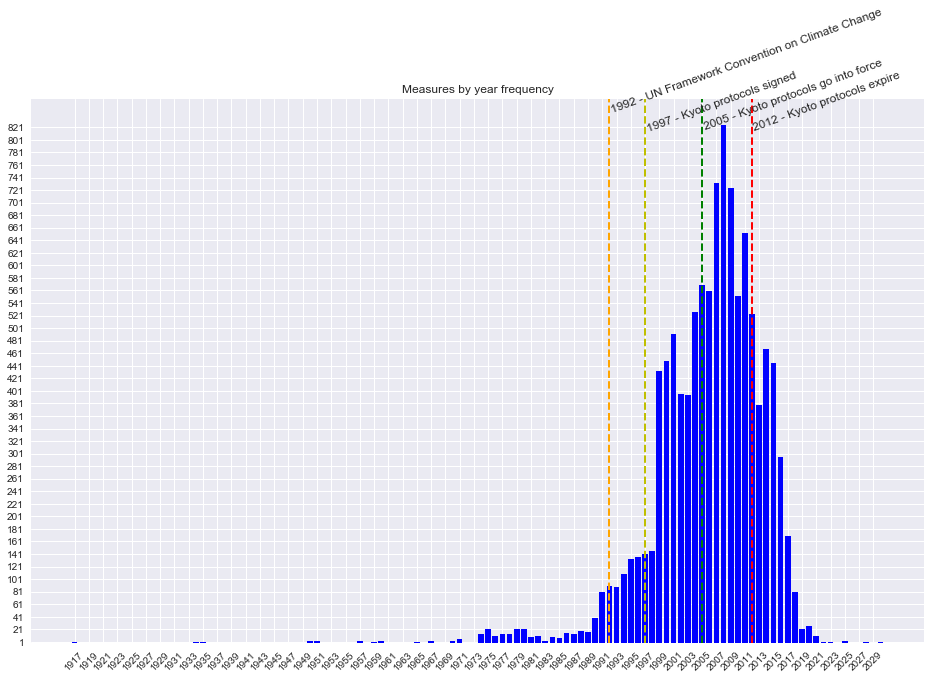

In [191]:
#plot total year with kyoto and other meeting lines
all_years = mdb['measure_implementation_period_start_year'].dropna().astype('int64').tolist()

ofreq_years = Counter(all_years)

x_years=[]
y_freq = []
for key, value in ofreq_years.items():
    x_years.append(key)
    y_freq.append(value)  

plt.figure(figsize=(16, 10))
plt.xticks(np.arange(min(x_years), max(x_years)+1, 2.0), rotation=45)
plt.yticks(np.arange(min(y_freq), max(y_freq)+1, 20.0))
plt.bar(x_years, y_freq, color='blue')

plt.axvline(x=1992, linewidth=2, color='orange', label='1992, United Nations Framework Convention on Climate Change', linestyle='--')
plt.text(1992,1000,'1992 - UN Framework Convention on Climate Change', rotation=20)

plt.axvline(x=1997, linewidth=2, color='y', label='1997, Kyoto protocols signed', linestyle='--')
plt.text(1997,900,'1997 - Kyoto protocols signed', rotation=20)

plt.axvline(x=2005, linewidth=2, color='g', label='2005, Kyoto protocols go into force', linestyle='--')
plt.text(2005,920,'2005 - Kyoto protocols go into force', rotation=20)


plt.axvline(x=2012, linewidth=2, color='r', label='2012, Kyoto protocols expire', linestyle='--')
plt.text(2012,900,'2012 - Kyoto protocols expire', rotation=20)


plt.title('Measures by year frequency')



Increased analysis can be done by adding when parties to the Kyoto Protocol ratified, data to be added to the Countries table with boolean column - 'kyoto' and 'ratification_year'

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Measure status <a id='status'></a>

In [47]:
#total number of recorded "active" measures in database
adb = mdb[(mdb.measure_status == 'Ongoing') | (mdb.measure_status =='Operational') | (mdb.measure_status =='In Force')]
print("Total number measures reported as 'Active' in dataset: ", len(adb))
print("'Active' is defined as measures coded: 'Ongoing','Operational', and 'In Force'. \n")

#number of recorded "active" measures by country
amc = {}

for c in countries:
    s = mdb[mdb['country'] == c][(mdb.measure_status == 'Ongoing') | (mdb.measure_status =='Operational') | (mdb.measure_status =='In Force')]
    amc[c] = str(len(s)) + ' of ' + str(len(csf[c]))
    
print("Measures reported as 'Active' by country: \n")
for c in sorted(amc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))




Total number measures reported as 'Active' in dataset:  6048
'Active' is defined as measures coded: 'Ongoing','Operational', and 'In Force'. 

Measures reported as 'Active' by country: 

	Albania: 16 of 20
	Algeria: 8 of 8
	Angola: 0 of 2
	Argentina: 19 of 30
	Armenia: 1 of 1
	Australia: 80 of 320
	Austria: 104 of 159
	Bangladesh: 1 of 1
	Belgium: 207 of 367
	Belize: 4 of 4
	Bhutan: 0 of 1
	Bolivia: 2 of 4
	Bosnia and Herzegovina: 8 of 8
	Brazil: 305 of 349
	Bulgaria: 57 of 128
	Burkina Faso: 1 of 1
	Cambodia: 4 of 8
	Canada: 367 of 536
	Cape Verde: 1 of 1
	Chile: 8 of 20
	China: 217 of 307
	Colombia: 4 of 6
	Congo, Rep.: 0 of 1
	Costa Rica: 20 of 23
	Croatia: 41 of 152
	Cyprus: 32 of 55
	Czech Republic: 79 of 175
	Denmark: 82 of 242
	Dominican Republic: 0 of 2
	Ecuador: 0 of 2
	Egypt, Arab Rep.: 1 of 1
	El Salvador: 1 of 1
	Estonia: 56 of 129
	European Union: 198 of 299
	Finland: 133 of 262
	France: 279 of 487
	Georgia: 8 of 13
	Germany: 332 of 569
	Ghana: 14 of 16
	Greece: 100 of 169

In [11]:
#total number of "completed or ended" measures in database
cdb = mdb[(mdb.measure_status == 'Completed') | (mdb.measure_status =='Implemented') | (mdb.measure_status =='Ended') | (mdb.measure_status =='Concluded') | (mdb.measure_status =='Adopted')]
print("Total number of measures reported as 'Completed' in dataset:", len(cdb))
print("'Completed' is defined as measures coded: 'Completed', 'Implemented', 'Ended', 'Concluded', and 'Adopted'. \n")

#number of "completed or ended" measures by country
cmc = {}
for c in countries:
    sc = mdb[mdb['country'] == c][(mdb.measure_status == 'Completed') | (mdb.measure_status =='Implemented') | (mdb.measure_status =='Ended') | (mdb.measure_status =='Concluded')]
    cmc[c] = str(len(sc)) + ' of ' + str(len(csf[c]))
    
print("Measures reported as 'Completed' by country:")
for c in sorted(cmc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))   




Total number of measures reported as 'Completed' in dataset: 3170
'Completed' is defined as measures coded: 'Completed', 'Implemented', 'Ended', 'Concluded', and 'Adopted'. 

Measures reported as 'Completed' by country:
	Albania: 0 of 20
	Algeria: 0 of 8
	Angola: 0 of 2
	Argentina: 0 of 30
	Armenia: 0 of 1
	Australia: 171 of 320
	Austria: 24 of 159
	Bangladesh: 0 of 1
	Belgium: 122 of 367
	Belize: 0 of 4
	Bhutan: 0 of 1
	Bolivia: 0 of 4
	Bosnia and Herzegovina: 0 of 8
	Brazil: 6 of 349
	Bulgaria: 50 of 128
	Burkina Faso: 0 of 1
	Cambodia: 0 of 8
	Canada: 83 of 536
	Cape Verde: 0 of 1
	Chile: 0 of 20
	China: 17 of 307
	Colombia: 0 of 6
	Congo, Rep.: 0 of 1
	Costa Rica: 2 of 23
	Croatia: 96 of 152
	Cyprus: 20 of 55
	Czech Republic: 61 of 175
	Denmark: 96 of 242
	Dominican Republic: 0 of 2
	Ecuador: 0 of 2
	Egypt, Arab Rep.: 0 of 1
	El Salvador: 0 of 1
	Estonia: 47 of 129
	European Union: 54 of 299
	Finland: 78 of 262
	France: 158 of 487
	Georgia: 0 of 13
	Germany: 176 of 569
	Ghana: 0 of

In [12]:
#total number of "canceled" measures in database
cndb = mdb[(mdb.measure_status == 'Canceled')]
print("Total number of measures reported as 'Canceled' in dataset:", len(cndb))
print("'Canceled' is defined as measures coded: 'Canceled' \n")
           
#number of "canceled" measures by country
cnc = {}
for c in countries:
    cm = mdb[mdb['country'] == c][(mdb.measure_status == 'Canceled')]
    cnc[c] = str(len(cm)) + ' of ' + str(len(csf[c]))
    
print("Measures reported as 'Canceled' by country:\n")
for c in sorted(cnc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))        

Total number of measures reported as 'Canceled' in dataset: 10
'Canceled' is defined as measures coded: 'Canceled' 

Measures reported as 'Canceled' by country:

	Albania: 0 of 20
	Algeria: 0 of 8
	Angola: 0 of 2
	Argentina: 0 of 30
	Armenia: 0 of 1
	Australia: 0 of 320
	Austria: 0 of 159
	Bangladesh: 0 of 1
	Belgium: 0 of 367
	Belize: 0 of 4
	Bhutan: 0 of 1
	Bolivia: 2 of 4
	Bosnia and Herzegovina: 0 of 8
	Brazil: 0 of 349
	Bulgaria: 0 of 128
	Burkina Faso: 0 of 1
	Cambodia: 0 of 8
	Canada: 0 of 536
	Cape Verde: 0 of 1
	Chile: 0 of 20
	China: 0 of 307
	Colombia: 0 of 6
	Congo, Rep.: 1 of 1
	Costa Rica: 1 of 23
	Croatia: 0 of 152
	Cyprus: 0 of 55
	Czech Republic: 0 of 175
	Denmark: 0 of 242
	Dominican Republic: 0 of 2
	Ecuador: 0 of 2
	Egypt, Arab Rep.: 0 of 1
	El Salvador: 0 of 1
	Estonia: 0 of 129
	European Union: 0 of 299
	Finland: 0 of 262
	France: 0 of 487
	Georgia: 3 of 13
	Germany: 0 of 569
	Ghana: 0 of 16
	Greece: 0 of 169
	Guatemala: 0 of 11
	Honduras: 0 of 3
	Hungary: 0 of 22

In [13]:
# total number of discrepancies between ongoing, active measures and measure end year
mdb['measure_implementation_period_end_year'] = pd.to_numeric(mdb.measure_implementation_period_end_year, errors='coerce')
ddb = mdb[(mdb.measure_status == 'Ongoing') | 
          (mdb.measure_status =='Operational') | 
          (mdb.measure_status =='In Force') & 
          (mdb.measure_implementation_period_end_year <= 2018) & 
          (mdb.measure_status != 'Completed') & 
          (mdb.measure_status !='Implemented') & 
          (mdb.measure_status !='Ended') &
          (mdb.measure_status !='Concluded') & 
          (mdb.measure_status !='Adopted') ]

ddb = ddb.dropna(subset=['measure_implementation_period_end_year'])

print("Total number of measures reported as 'Active' but have an 'implementation end year' that has "+
      "passed which denotes a reporting discrepancy in measure implementation status:",  len(ddb), "\n")

# number of discrepancies between ongoing, active measures and measure end year by country
dmc = {}
for c in countries:
    dm = mdb[mdb['country'] == c][(mdb.measure_status == 'Ongoing') | 
          (mdb.measure_status =='Operational') | 
          (mdb.measure_status =='In Force') & 
          (mdb.measure_implementation_period_end_year <= 2018) & 
          (mdb.measure_status != 'Completed') & 
          (mdb.measure_status !='Implemented') & 
          (mdb.measure_status !='Ended') &
          (mdb.measure_status !='Concluded') & 
          (mdb.measure_status !='Adopted') ]
    
    dm = dm.dropna(subset=['measure_implementation_period_end_year'])
    
    dmc[c] = str(len(dm)) + ' of ' + str(len(csf[c]))

print("Measures with status reporting discrepancy by country:\n")
for c in sorted(dmc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))

Total number of measures reported as 'Active' but have an 'implementation end year' that has passed which denotes a reporting discrepancy in measure implementation status: 550 

Measures with status reporting discrepancy by country:

	Albania: 1 of 20
	Algeria: 0 of 8
	Angola: 0 of 2
	Argentina: 11 of 30
	Armenia: 0 of 1
	Australia: 2 of 320
	Austria: 1 of 159
	Bangladesh: 0 of 1
	Belgium: 0 of 367
	Belize: 4 of 4
	Bhutan: 0 of 1
	Bolivia: 0 of 4
	Bosnia and Herzegovina: 0 of 8
	Brazil: 221 of 349
	Bulgaria: 5 of 128
	Burkina Faso: 1 of 1
	Cambodia: 3 of 8
	Canada: 36 of 536
	Cape Verde: 1 of 1
	Chile: 1 of 20
	China: 38 of 307
	Colombia: 0 of 6
	Congo, Rep.: 0 of 1
	Costa Rica: 17 of 23
	Croatia: 0 of 152
	Cyprus: 0 of 55
	Czech Republic: 3 of 175
	Denmark: 0 of 242
	Dominican Republic: 0 of 2
	Ecuador: 0 of 2
	Egypt, Arab Rep.: 0 of 1
	El Salvador: 1 of 1
	Estonia: 0 of 129
	European Union: 5 of 299
	Finland: 0 of 262
	France: 8 of 487
	Georgia: 1 of 13
	Germany: 7 of 569
	Ghana: 0 o

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Financial Reporting <a id='finance'></a>

In [15]:
#total number of reported costs values in dataset
fcdb = mdb['measure_financing_quantity'].dropna()
print('Total number of measures with reported financing cost:', len(fcdb))

#number of reported cost values by country
fmc = {}
for c in countries:
    fm = mdb[mdb['country'] == c]['measure_financing_quantity'].dropna()
    
    fmc[c] = str(len(fm)) + ' of ' + str(len(csf[c]))
    
print("Measures with reported financial cost by country:\n")
for c in sorted(fmc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))


Total number of measures with reported financing cost: 4549
Measures with reported financial cost by country:

	Albania: 10 of 20
	Algeria: 1 of 8
	Angola: 2 of 2
	Argentina: 30 of 30
	Armenia: 1 of 1
	Australia: 150 of 320
	Austria: 54 of 159
	Bangladesh: 1 of 1
	Belgium: 92 of 367
	Belize: 4 of 4
	Bhutan: 1 of 1
	Bolivia: 4 of 4
	Bosnia and Herzegovina: 4 of 8
	Brazil: 313 of 349
	Bulgaria: 83 of 128
	Burkina Faso: 1 of 1
	Cambodia: 8 of 8
	Canada: 186 of 536
	Cape Verde: 1 of 1
	Chile: 20 of 20
	China: 132 of 307
	Colombia: 6 of 6
	Congo, Rep.: 1 of 1
	Costa Rica: 23 of 23
	Croatia: 70 of 152
	Cyprus: 40 of 55
	Czech Republic: 76 of 175
	Denmark: 42 of 242
	Dominican Republic: 2 of 2
	Ecuador: 2 of 2
	Egypt, Arab Rep.: 1 of 1
	El Salvador: 1 of 1
	Estonia: 56 of 129
	European Union: 124 of 299
	Finland: 116 of 262
	France: 143 of 487
	Georgia: 13 of 13
	Germany: 173 of 569
	Ghana: 0 of 16
	Greece: 61 of 169
	Guatemala: 11 of 11
	Honduras: 3 of 3
	Hungary: 85 of 220
	Iceland: 0 of 2


We are currently missing the reported costs of EU member countries measures from the EEA database, the data for those countries is currently being collected and processed.

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Measure Targets <a id='targets'></a>

Measure targets are defined as the industry(ies), and/or sector(s) a given measure is intended to affect.

In [53]:
#load in targets csv
targets = pd.read_csv('exports/MeasureTarget.csv')
print("Total measure targets in dataset:", len(set(targets['measure_target'])),"\n")

print("Targets: \n\t", '\n\t'.join(set(targets['measure_target'])))

#store in dictionary:
mtc = {}

for t in set(targets['measure_target']):
             mtc[t] = 0

Total measure targets in dataset: 186 

Targets: 
	 small- and medium-sized enterprises (smes)
	biofuel
	all sectors
	utility
	compressors
	energy sector
	all
	onshore
	energy class
	biomass for heat
	oil)
	biofuels for transport
	heavy-duty vehicles
	solar thermal electricity (ste)
	light manufacturing
	prescriptive
	building materials
	iron and steel
	kitchens & laundry
	waste
	power
	multi-sectoral policy
	transport
	water heating
	pumps
	district heating and cooling
	compressed natural gas
	energy supply
	eco-driving
	solar heat
	passenger
	fuel (conventional and alternative)
	appliances
	energy utilities
	energy consumption
	distribution transformers
	metal articles
	end-use services
	chp
	electricity generation
	hybrid vehicles
	lamp technologies
	infrastructure and planning
	renewable heat pumps
	demand-side management
	waste management
	land use change and forestry
	light-duty vehicles
	energy-intensive
	standby
	wind
	bioethanol
	data centers & ict
	electricity
	storage
	low e

In [54]:
#measure targets by the numbers
for i, r in mdb.dropna(subset=['measure_target']).iterrows():
    splits = r['measure_target'].split(',')
    for t in mtc.keys():
        if t in splits:
            mtc[t] +=1 

print("Measures by target frequency: \n")            
for c in sorted(mtc.items(), key=operator.itemgetter(1)):
    print('\t' + c[0] + ': ' + str(c[1]))

Measures by target frequency: 

	waste: 0
	energy supply: 0
	energy consumption: 0
	waste management: 0
	land use change and forestry: 0
	other sectors: 0
	cross-cutting: 0
	energy production: 0
	agriculture: 0
	land use: 0
	resilience : 0
	district heating and cooling: 1
	infrastructure and planning: 1
	land-use planning: 1
	liquefied petroleum gas: 1
	individual vehicle: 1
	road: 1
	intelligent transportation (for freight): 1
	in-car feedback: 1
	ground source heat pumps: 1
	non-road: 1
	nuclear: 1
	light manufacturing: 2
	data centers & ict: 2
	diesel: 2
	all-electric vehicles: 2
	utility: 3
	compressed natural gas: 3
	fuel (conventional and alternative): 3
	conventional fuel: 3
	tyres: 3
	fuel efficiency standards: 3
	fittings and controls: 3
	plug-in hybrid vehicles: 3
	distribution transformers: 4
	solar thermal electricity (ste): 5
	kitchens & laundry: 5
	renewable heat pumps: 5
	off-grid: 5
	biofuel: 6
	compressors: 6
	pumps: 6
	energy-intensive: 6
	construction: 6
	mining: 6
	

There is overlap with some of the target categories. We will account for this in the online tool on the query side with relevant groups such as 'land', 'energy', etc. There are also a couple of targets with 0 reported measures. This is also a function of the way we parse the targets and will be reflected slightly differently in the online database.


#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Measure jurisdiction <a id='jurisdiction'></a>

In [55]:
jurisdiction = pd.read_csv("exports/Jurisdiction.csv")

print("Total number of reported jurisdictions (unique) in dataset:", len(jurisdiction), '\n')
print("Jurisdictions:\n\t" + '\n\t'.join(jurisdiction['jurisdiction'].tolist()))

Total number of reported jurisdictions (unique) in dataset: 32 

Jurisdictions:
	energy agencies
	state/regional
	trade associations
	energy suppliers
	individual passengers
	utilities
	general public
	government
	financial institut.
	local
	vehicle manufacturers
	international
	manufacturers
	national
	local authorities
	regional
	financial institutions
	prof. associations
	transport companies
	local government
	municipal
	energy supplier
	other
	employers
	research
	no information
	federal
	state/provincial
	central government
	industries
	associations
	companies


Here there is also overlap that will be standardized.

In [91]:
#store jurisdictions in dictionary
jc={} 
for j in jurisdiction['jurisdiction'].tolist():
    jc[j] = 0


#measure jurisdiction by the numbers
for i, r in mdb.dropna(subset=['jurisdiction']).iterrows():
    if ',' in  r['jurisdiction']:
        splits = r['jurisdiction'].split(',')
        splits = [x.lower().strip() for x in splits]
        for t in jc.keys():
            if t in splits:
                jc[t] +=1 
    else:
        for t in jc.keys():
            if t in r['jurisdiction'].lower():
                jc[t] +=1

print("Measures by jurisdiction frequency: \n")            
for c in sorted(jc.items(), key=operator.itemgetter(1)):
    print('\t' + c[0] + ': ' + str(c[1]))


Measures by jurisdiction frequency: 

	individual passengers: 1
	general public: 1
	no information: 2
	research: 7
	employers: 22
	energy supplier: 28
	financial institut.: 43
	trade associations: 53
	utilities: 64
	vehicle manufacturers: 64
	financial institutions: 74
	industries: 79
	prof. associations: 99
	municipal: 108
	other: 109
	energy suppliers: 118
	transport companies: 118
	companies: 122
	state/provincial: 129
	associations: 131
	local government: 135
	manufacturers: 156
	international: 268
	local: 273
	local authorities: 406
	energy agencies: 486
	state/regional: 641
	regional: 748
	federal: 778
	central government: 1642
	government: 2240
	national: 4088


In [103]:
#reported jurisdictions by country (in list format is fine)
#get which countres measures reference greenhouse gases

jnc = {}
for c in countries:
    jn = mdb[mdb['country'] == c]['jurisdiction'].dropna()
    
    if len(jn) > 0:
        flat_jn =[]
        ig = jn.tolist()
        
        for each in ig:
            if ',' in each:
                flat_jn.extend([x.lower().strip() for x in each.split(',') if '..' not in x])
                
            else:
                if '..' not in each:
                    flat_jn.append(each.lower().strip())
                    
             
        jnc[c] = list(set(flat_jn))
        
    else:
        
        jnc[c] = 'None recorded'

print('Jurisdictions reported by measures by country: \n')
for c in sorted(jnc.items(), key=operator.itemgetter(0)):
    print(c[0] + ': ' + str(', '.join(c[1])) + '\n')



Jurisdictions reported by measures by country: 

Albania: international, federal, state/regional, municipal, national

Algeria: national

Angola: federal

Argentina: federal, state/provincial

Armenia: federal

Australia: national, international, municipal, state/regional

Austria: international, central government, local government, utilities, manufacturers, state/regional, energy agencies, energy suppliers, local authorities, prof. associations, regional, municipal, national, government, associations, transport companies

Bangladesh: federal

Belgium: international, central government, local government, utilities, trade associations, manufacturers, companies, state/regional, employers, energy agencies, local authorities, local, prof. associations, regional, municipal, national, government, transport companies

Belize: federal

Bhutan: federal

Bolivia: federal

Bosnia and Herzegovina: national, state/regional

Brazil: international, federal, state/regional, state/provincial, municipa

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Measures agencies <a id='agencies'></a>

In [56]:
#reported number of agencies for each country
agencies = mdb['agency']


#average number of agencies per completed measure per country
ajc = {}
for c in countries:
    #create list to append length of agency list so you can run average on it for each country
    ajc[c] = []
    ag = mdb[mdb['country'] == c].dropna(subset=['agency'])['agency']

    for r in ag:
        
       # if comma or ; split and get len of split, add number to larger list 
        if ',' in r:
            jc = r.split(',')
            ajc[c].append(len(jc))
            
        elif ';' in r:
            jc = r.split(';')
            ajc[c].append(len(jc))
            
        else:
            ajc[c].append(1)

#compute averages
aja = {}

for c, a in ajc.items():
    
    #print(len(a))
    if len(a) == 0:
        aja[c] = 0
    
    else:
        aja[c] = round(sum(a)/len(a))
    
print('Average number of agencies per measure by country: \n')
for c in sorted(aja.items(), key=operator.itemgetter(1)):
    print('\t' + c[0] + ': ' + str(c[1]))



Average number of agencies per measure by country: 

	Nigeria: 0
	Guatemala: 0
	Pakistan: 0
	Philippines: 0
	Cape Verde: 0
	Bangladesh: 0
	Burkina Faso: 0
	Tonga: 0
	Ukraine: 0
	Lao PDR: 0
	Nicaragua: 0
	Angola: 0
	Uruguay: 0
	Morocco: 0
	Vietnam: 0
	Bolivia: 0
	Bhutan: 0
	Honduras: 0
	Serbia: 0
	Kazakhstan: 0
	Georgia: 0
	Zambia: 0
	Peru: 0
	Chile: 0
	Dominican Republic: 0
	Nepal: 0
	Myanmar: 0
	Kenya: 0
	Ecuador: 0
	Belize: 0
	Madagascar: 0
	Liberia: 0
	Costa Rica: 0
	Sri Lanka: 0
	Tajikistan: 0
	Panama: 0
	S?o Tom? and Principe: 0
	Sierra Leone: 0
	Armenia: 0
	Congo, Rep.: 0
	Thailand: 0
	Cambodia: 0
	Vanuatu: 0
	Tanzania: 0
	Egypt, Arab Rep.: 0
	El Salvador: 0
	Uganda: 0
	Russian Federation: 0
	Argentina: 0
	Colombia: 0
	Iran, Islamic Rep.: 0
	Malta: 1
	China: 1
	Czech Republic: 1
	Russia: 1
	Finland: 1
	Indonesia: 1
	India: 1
	Australia: 1
	Mauritius: 1
	Poland: 1
	Norway: 1
	South Africa: 1
	Canada: 1
	Ghana: 1
	Latvia: 1
	Italy: 1
	Iran: 1
	Montenegro: 1
	Luxembourg: 1
	Turkey: 

#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

### Measures types is currently being teased out, will be updated soon.

### Measures GHG Data <a id='ghg'></a>

This data is currently being parsed for more sources and will be added back in soon.

In [65]:
#get grenhouse gases referenced
ghga = set(mdb['ghgs_affected'].dropna().tolist())

ghga_list=[]
for g in ghga:
    if ',' in g:
        for h in g.split(','):
            
            if h not in ghga_list:
                ghga_list.append(h.strip())
                
    else:
        if g not in ghga_list:
            ghga_list.append(g.strip())
        
    

print('Total unique greenhouse gases referenced in dataset:', len(set(ghga_list)), '\n')
print('Greenhouse gases:\n', '\t'.join(set(ghga_list)))


Total unique greenhouse gases referenced in dataset: 7 

Greenhouse gases:
 CH4	NF3	SF6	N2O	CO2	HFC	PFC


In [105]:
#get which countres measures reference greenhouse gases

gnc = {}
for c in countries:
    gn = mdb[mdb['country'] == c]['ghgs_affected'].dropna()
    
    if len(gn) > 0:
        flat_gn =[]
        ig = gn.tolist()
        
        for each in ig:
            if ',' in each:
                flat_gn.extend([x.strip() for x in each.split(',')])
                
            else:
                flat_gn.append(each.strip())
            
        gnc[c] = list(set(flat_gn))
        
    else:
        
        gnc[c] = 'None recorded'

print('GHGs targeted by measures by country: \n')
for c in sorted(gnc.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))


GHGs targeted by measures by country: 

	Albania: None recorded
	Algeria: None recorded
	Angola: None recorded
	Argentina: None recorded
	Armenia: None recorded
	Australia: None recorded
	Austria: ['CH4', 'NF3', 'SF6', 'N2O', 'CO2', 'HFC', 'PFC']
	Bangladesh: None recorded
	Belgium: ['CH4', 'NF3', 'SF6', 'N2O', 'CO2', 'HFC', 'PFC']
	Belize: None recorded
	Bhutan: None recorded
	Bolivia: None recorded
	Bosnia and Herzegovina: None recorded
	Brazil: None recorded
	Bulgaria: ['CH4', 'N2O', 'CO2', 'HFC', 'PFC']
	Burkina Faso: None recorded
	Cambodia: None recorded
	Canada: None recorded
	Cape Verde: None recorded
	Chile: None recorded
	China: None recorded
	Colombia: None recorded
	Congo, Rep.: None recorded
	Costa Rica: None recorded
	Croatia: ['CH4', 'SF6', 'N2O', 'CO2', 'HFC', 'PFC']
	Cyprus: ['CH4', 'SF6', 'N2O', 'CO2', 'HFC']
	Czech Republic: ['CH4', 'NF3', 'SF6', 'N2O', 'CO2', 'HFC', 'PFC']
	Denmark: ['CH4', 'SF6', 'N2O', 'CO2', 'HFC', 'PFC']
	Dominican Republic: None recorded
	Ecuad

In [114]:
#get total number of measures with reduction targets
rt = mdb[['total_ghg_emissions_reductions_in_2020', 'total_ghg_emissions_reductions_in_2030']].dropna(subset=['total_ghg_emissions_reductions_in_2020', 'total_ghg_emissions_reductions_in_2030'], how='all')
print('Total number of measures with reduction targets in 2020 or 2030:', len(rt), '\n')

#get total number of measures with reported reduction targets by country 
ghgt = {}
for c in countries:
    gh = mdb[mdb['country'] == c][['total_ghg_emissions_reductions_in_2020', 'total_ghg_emissions_reductions_in_2030']].dropna(subset=['total_ghg_emissions_reductions_in_2020', 'total_ghg_emissions_reductions_in_2030'], how='all')
    
    ghgt[c] = str(len(gh)) + ' of ' + str(len(csf[c]))
    
print("Measures with reported ghg reduction targets in 2020 or 2030:\n")
for c in sorted(ghgt.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))


Total number of measures with reduction targets in 2020 or 2030: 571 

Measures with reported ghg reduction targets in 2020 or 2030:

	Albania: 0 of 20
	Algeria: 0 of 8
	Angola: 0 of 2
	Argentina: 0 of 30
	Armenia: 0 of 1
	Australia: 0 of 320
	Austria: 4 of 159
	Bangladesh: 0 of 1
	Belgium: 45 of 367
	Belize: 0 of 4
	Bhutan: 0 of 1
	Bolivia: 0 of 4
	Bosnia and Herzegovina: 0 of 8
	Brazil: 0 of 349
	Bulgaria: 0 of 128
	Burkina Faso: 0 of 1
	Cambodia: 0 of 8
	Canada: 0 of 536
	Cape Verde: 0 of 1
	Chile: 0 of 20
	China: 0 of 307
	Colombia: 0 of 6
	Congo, Rep.: 0 of 1
	Costa Rica: 0 of 23
	Croatia: 15 of 152
	Cyprus: 0 of 55
	Czech Republic: 43 of 175
	Denmark: 9 of 242
	Dominican Republic: 0 of 2
	Ecuador: 0 of 2
	Egypt, Arab Rep.: 0 of 1
	El Salvador: 0 of 1
	Estonia: 40 of 129
	European Union: 0 of 299
	Finland: 27 of 262
	France: 15 of 487
	Georgia: 0 of 13
	Germany: 57 of 569
	Ghana: 0 of 16
	Greece: 16 of 169
	Guatemala: 0 of 11
	Honduras: 0 of 3
	Hungary: 6 of 220
	Iceland: 0 of 2
	

#### GHG target reductions 
The measurement used in this dataset is kt CO2eq/y, which is the carbon dioxide equivalent (per year)—a measure used to compare the emissions from various greenhouse gases based upon their global warming potential.<sup>1</sup> 
<br><br>Thinking about folding in this data...
https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE

___
<sup>1</sup> Environmental Indicators for Agriculture – Vol. 3: Methods and Results, OECD, 2001, glossary, pages 389-391.

In [126]:
#get total reduction target average for measures by 2020
r20 = mdb['total_ghg_emissions_reductions_in_2020'].dropna()
print('Global average of reported target reductions for 2020:', sum(r20)/len(r20), '(kt CO2eq/y)\n')


#get by country
#get total number of measures with reported reduction targets by country 
ghg20 = {}
for c in countries:
    gh = mdb[mdb['country'] == c]['total_ghg_emissions_reductions_in_2020'].dropna()
    if len(gh) > 0:
        ghg20[c] = str(sum(gh)/len(gh)) + ' (kt CO2eq/y)\n'
    
print("Average targeted ghg reductions in 2020 by country:\n")
for c in sorted(ghg20.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))



Global average of reported target reductions for 2020: 1046.797794117647 (kt CO2eq/y)

Average targeted ghg reductions in 2020 by country:

	Austria: 1382.75 (kt CO2eq/y)

	Belgium: 714.9777777777778 (kt CO2eq/y)

	Croatia: 223.33333333333334 (kt CO2eq/y)

	Czech Republic: 582.2857142857143 (kt CO2eq/y)

	Denmark: 5077.25 (kt CO2eq/y)

	Estonia: 96.15 (kt CO2eq/y)

	Finland: 1527.8636363636363 (kt CO2eq/y)

	France: 4729.533333333334 (kt CO2eq/y)

	Germany: 962.290909090909 (kt CO2eq/y)

	Greece: 2175.125 (kt CO2eq/y)

	Hungary: 305.8333333333333 (kt CO2eq/y)

	Ireland: 258.39473684210526 (kt CO2eq/y)

	Italy: 2041.9032258064517 (kt CO2eq/y)

	Latvia: 65.64 (kt CO2eq/y)

	Lithuania: 1009.5 (kt CO2eq/y)

	Luxembourg: 18.5625 (kt CO2eq/y)

	Malta: 44.25 (kt CO2eq/y)

	Netherlands: 1938.235294117647 (kt CO2eq/y)

	Portugal: 0.0 (kt CO2eq/y)

	Romania: 680.1538461538462 (kt CO2eq/y)

	Slovakia: 109.06666666666666 (kt CO2eq/y)

	Slovenia: 132.84615384615384 (kt CO2eq/y)

	Spain: 653.5769230

In [127]:
#get total reduction target average for measures by 2020
r30 = mdb['total_ghg_emissions_reductions_in_2030'].dropna()
print('Global average of reported target reductions for 2030:', sum(r30)/len(r30), '(kt CO2eq/y)\n')


#get by country
#get total number of measures with reported reduction targets by country 
ghg30 = {}
for c in countries:
    gh = mdb[mdb['country'] == c]['total_ghg_emissions_reductions_in_2030'].dropna()
    if len(gh) > 0:
        ghg30[c] = str(sum(gh)/len(gh)) + ' (kt CO2eq/y)\n'
    
print("Average targeted ghg reductions in 2030 by country:\n")
for c in sorted(ghg30.items(), key=operator.itemgetter(0)):
    print('\t' + c[0] + ': ' + str(c[1]))


Global average of reported target reductions for 2030: 1483.9525609756097 (kt CO2eq/y)

Average targeted ghg reductions in 2030 by country:

	Austria: 742.0 (kt CO2eq/y)

	Belgium: 991.1190476190476 (kt CO2eq/y)

	Croatia: 361.9866666666667 (kt CO2eq/y)

	Czech Republic: 668.0238095238095 (kt CO2eq/y)

	Denmark: 600.0 (kt CO2eq/y)

	Estonia: 124.35 (kt CO2eq/y)

	Finland: 1746.8076923076924 (kt CO2eq/y)

	France: 9010.866666666667 (kt CO2eq/y)

	Germany: 2253.2 (kt CO2eq/y)

	Greece: 4457.75 (kt CO2eq/y)

	Hungary: 300.5 (kt CO2eq/y)

	Ireland: 295.11179487179487 (kt CO2eq/y)

	Italy: 4212.35 (kt CO2eq/y)

	Latvia: 69.36 (kt CO2eq/y)

	Luxembourg: 38.357142857142854 (kt CO2eq/y)

	Malta: 54.85 (kt CO2eq/y)

	Netherlands: 4281.875 (kt CO2eq/y)

	Romania: 1203.3076923076924 (kt CO2eq/y)

	Slovakia: 147.8 (kt CO2eq/y)

	Slovenia: 252.30769230769232 (kt CO2eq/y)

	Spain: 852.1428571428571 (kt CO2eq/y)

	Sweden: 8200.0 (kt CO2eq/y)

	United Kingdom: 3145.102564102564 (kt CO2eq/y)



#### Jump to: [Summary](#summary)  [Countries](#countries)  [Years](#years)  [Status](#status)  [Finance](#finance) [Targets](#targets)  [Jurisdiction](#jurisdiction)  [Agencies](#agencies)  [GHG data](#ghg)

#### Roadmap:

* Additional GHG and finance data for existing records
* Addition of 2000 parsed US measures by state
* Completed EU member countries and subset with comparative analysis of EU listed policies and seperate member countries
* Completed OECD member countries subset